### 📕 Importamos liberias

In [1]:
# Importamos liberias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import zscore
import numpy as np
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams["axes.formatter.useoffset"] = False

data = pd.read_csv('datos_dengue_TF.csv')

### 📌 Exploracion de datos

In [2]:
data.head()

,departamento,provincia,distrito,enfermedad,ano,semana,edad,sexo
0,LORETO,ALTO AMAZONAS,YURIMAGUAS,DENGUE SIN SENALES DE ALARMA,2019,1,55,F
1,LORETO,ALTO AMAZONAS,YURIMAGUAS,DENGUE SIN SENALES DE ALARMA,2019,1,15,F
2,LORETO,ALTO AMAZONAS,YURIMAGUAS,DENGUE SIN SENALES DE ALARMA,2019,1,22,F
3,LORETO,ALTO AMAZONAS,YURIMAGUAS,DENGUE SIN SENALES DE ALARMA,2019,1,53,M
4,LORETO,ALTO AMAZONAS,YURIMAGUAS,DENGUE CON SENALES DE ALARMA,2019,1,15,M


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171282 entries, 0 to 171281
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   departamento  171282 non-null  object
 1   provincia     171282 non-null  object
 2   distrito      171282 non-null  object
 3   enfermedad    171282 non-null  object
 4   ano           171282 non-null  int64 
 5   semana        171282 non-null  int64 
 6   edad          171282 non-null  int64 
 7   sexo          171282 non-null  object
dtypes: int64(3), object(5)
memory usage: 10.5+ MB


In [4]:
print(data.describe())

                 ano         semana           edad
count  171282.000000  171282.000000  171282.000000
mean     2020.910376      25.560876      28.968123
std         0.999317      16.174886      86.675928
min      2019.000000       1.000000       1.000000
25%      2020.000000      12.000000      14.000000
50%      2021.000000      21.000000      26.000000
75%      2022.000000      43.000000      40.000000
max      2022.000000      53.000000   35109.000000


### ⌛ Tratamiento de datos

In [5]:
# Las siguientes columnas cuentan con datos incorrectos "/N", las reemplazaremos por "Otros" antes de castear el tipo de dato
columnas_modificar = ['departamento', 'provincia', 'distrito']

for columna in columnas_modificar:
    data[columna] = data[columna].replace('\\N', data[columna].mode()[0])


In [6]:
# Casteo de las columnas a categoricos
columns = ["departamento", "provincia", 'distrito', "enfermedad", 'sexo']

for col in columns:
  data[col] = data[col].astype('category')

In [7]:
# Verificamos el cambio, adiicionalmente vemos que hubo una optimizacion de memoria de 10.5+ mb --> 4.9 mb
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171282 entries, 0 to 171281
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   departamento  171282 non-null  category
 1   provincia     171282 non-null  category
 2   distrito      171282 non-null  category
 3   enfermedad    171282 non-null  category
 4   ano           171282 non-null  int64   
 5   semana        171282 non-null  int64   
 6   edad          171282 non-null  int64   
 7   sexo          171282 non-null  category
dtypes: category(5), int64(3)
memory usage: 4.9 MB


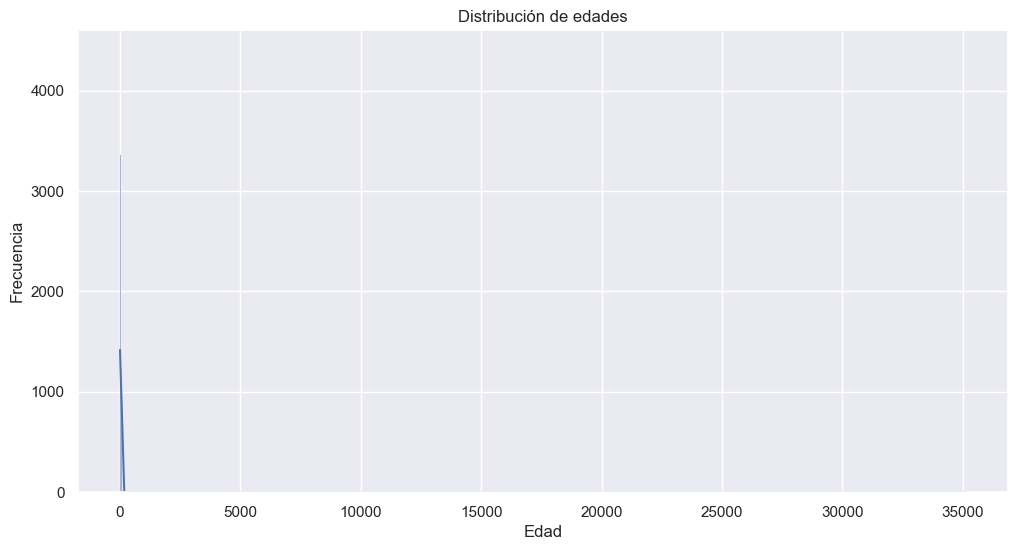

In [8]:
# Asimismo, con data.describe() podemos ver que la columna "edad" tiene un valor maximo de 35,109 anios, lo cual es imposible
sns.histplot(data['edad'], kde=True)

# Etiquetas 
plt.title('Distribución de edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

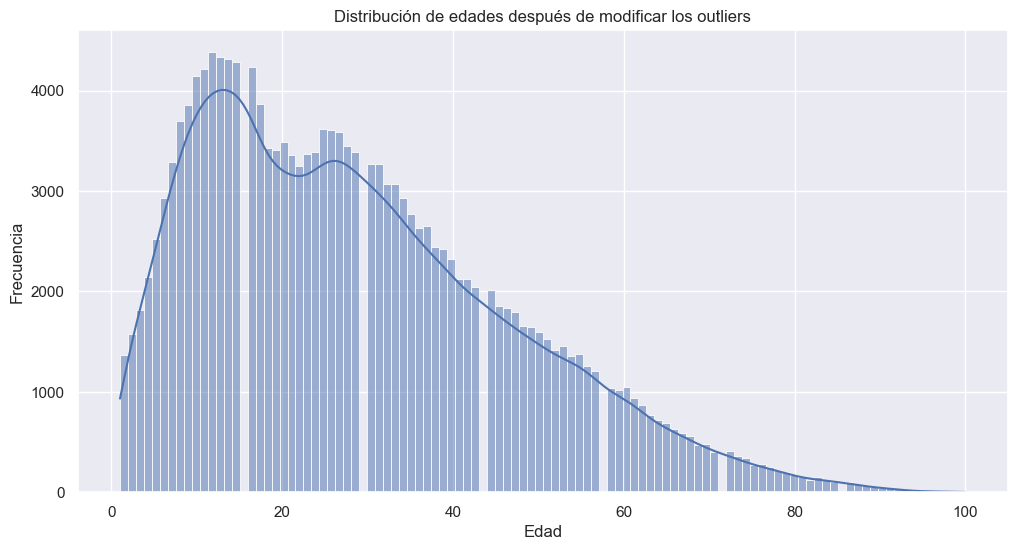

In [9]:
outliers_edad = data[data['edad'] > 100] # Consideramos 100 como limite razonable

# Obtenemos la media y desviación de la columna "edad"
media = data['edad'].mean() # 28.96
desviacion = data['edad'].std() # 86.67 Demasiado alto para considerar como un valor razonable

# Reemplazamos los outliers a partir de una distribución normal
np.random.seed(42)
valores_nomales = np.random.normal(media, desviacion, size=outliers_edad.shape[0]).astype(int)

# Modificamos los valores de la columna "edad" en el dataframe original
data.loc[data['edad'] > 100, 'edad'] = np.clip(valores_nomales, 1, 100).astype(int)

# Verificamos que no haya mas outliers
sns.histplot(data['edad'], kde=True)

# Etiquetas
plt.title('Distribución de edades después de modificar los outliers')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

In [10]:
# Dividimos la edad en grupos de ["niño", "joven", "adulto", "adulto mayor"]

bins = [0, 12, 18, 35, 100]
labels = ["niño", "joven", "adulto", "adulto mayor"]

data['grupo_edad'] = pd.cut(data['edad'], bins=bins, labels=labels, right=False).astype('category')

# Exportamos el archivo csv con los datos procesados para realizar un dashboard en PowerBI
data.to_csv('datos_denge_tratado.csv')
data.describe()

,ano,semana,edad
count,171282.000000,171282.000000,171282.000000
mean,2020.910376,25.560876,28.761142
std,0.999317,16.174886,18.105331
min,2019.000000,1.000000,1.000000
25%,2020.000000,12.000000,14.000000
50%,2021.000000,21.000000,26.000000
75%,2022.000000,43.000000,40.000000
max,2022.000000,53.000000,100.000000


### 🖼️ Visualizacion de datos

### Evolución de la dengue en el Perú

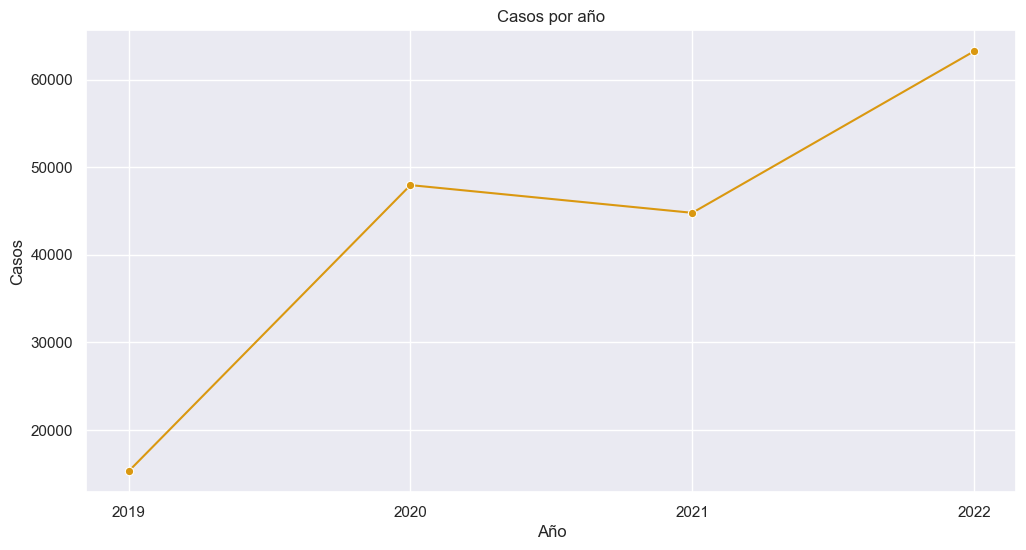

              casos
count      4.000000
mean   42820.500000
std    20027.945851
min    15311.000000
25%    37421.750000
50%    46373.000000
75%    51771.750000
max    63225.000000


In [11]:
# Agrupamos por año
casos_por_ano = data.groupby('ano', observed=False).size().reset_index(name='casos')
casos_por_ano["ano"] = casos_por_ano["ano"].astype('str')

# Gráfico de los casos por año
sns.lineplot(data=casos_por_ano, x='ano', y='casos', marker='o', color='#da9810')

# Etiquetas
plt.xlabel('Año')
plt.ylabel('Casos')
plt.title('Casos por año')

plt.show()
print(casos_por_ano.describe())

### ¿Qué departamentos tienen más casos de dengue?

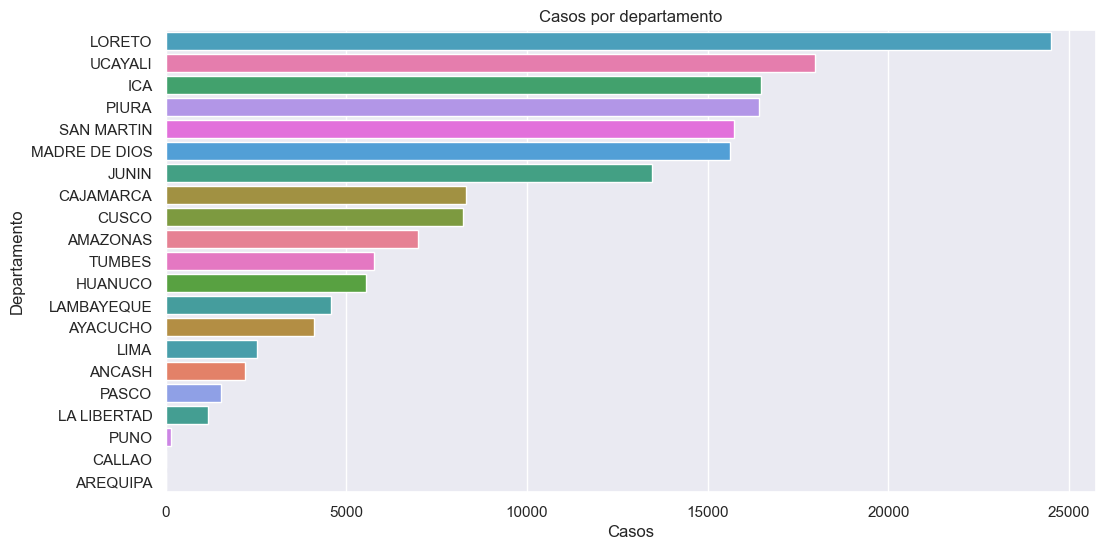

In [12]:
# Casos por departamento
casos_por_departamento = data.groupby('departamento', observed=False).size().reset_index(name='casos')


# Gráfico
sns.countplot(data=data, y="departamento", hue='departamento', order=casos_por_departamento.sort_values('casos', ascending=False).departamento)

# Etiquetas
plt.title("Casos por departamento")
plt.ylabel("Departamento")
plt.xlabel("Casos")

# Mostrar el gráfico
plt.show()


### ¿Cuáles son las 5 provincias o 5 distritos más afectados? 


In [13]:
mayores_provincias_afectadas = data.groupby('provincia', observed=False).size().reset_index(name='casos').sort_values('casos', ascending=False).head()
mayores_distritos_afectadas = data.groupby('distrito', observed=False).size().reset_index(name='casos').sort_values('casos', ascending=False).head()
print(mayores_distritos_afectadas)

       distrito  casos
440   TAMBOPATA   9191
44     CALLERIA   7087
493  YURIMAGUAS   6774
174        JAEN   6035
161         ICA   3989


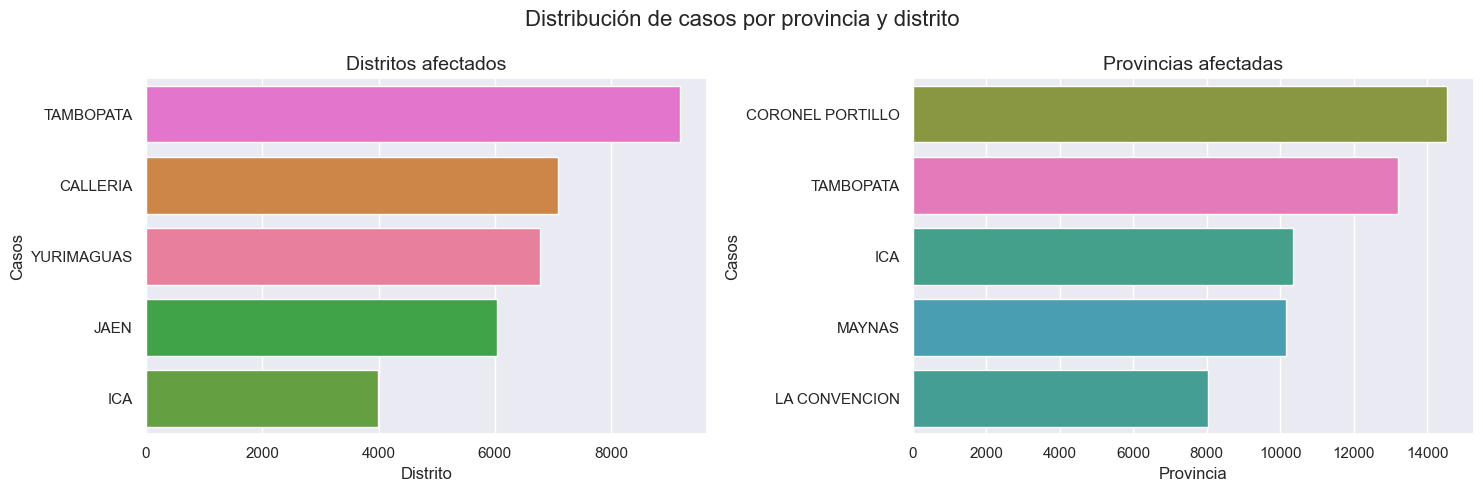

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Distribución de casos por provincia y distrito', fontsize=16)

# Grafico de los distritos mas afectados
sns.countplot(data=data, y="distrito", hue='distrito', order=mayores_distritos_afectadas.sort_values('casos', ascending=False).distrito, ax=axs[0])

sns.countplot(data=data, y="provincia", hue='provincia', order=mayores_provincias_afectadas.sort_values('casos', ascending=False).provincia, ax=axs[1])

# Titulo y etiquetas
axs[0].set_title('Distritos afectados', fontsize=14)
axs[0].set_xlabel('Distrito', fontsize=12)
axs[0].set_ylabel('Casos', fontsize=12)

axs[1].set_title('Provincias afectadas', fontsize=14)
axs[1].set_xlabel('Provincia', fontsize=12)
axs[1].set_ylabel('Casos', fontsize=12)

plt.tight_layout()
plt.show()

### ¿Hay alguna departamento con un aumento inusual de casos en cierto año? 

   departamento   ano  casos
67        PIURA  2022  12150
81      UCAYALI  2020   9781


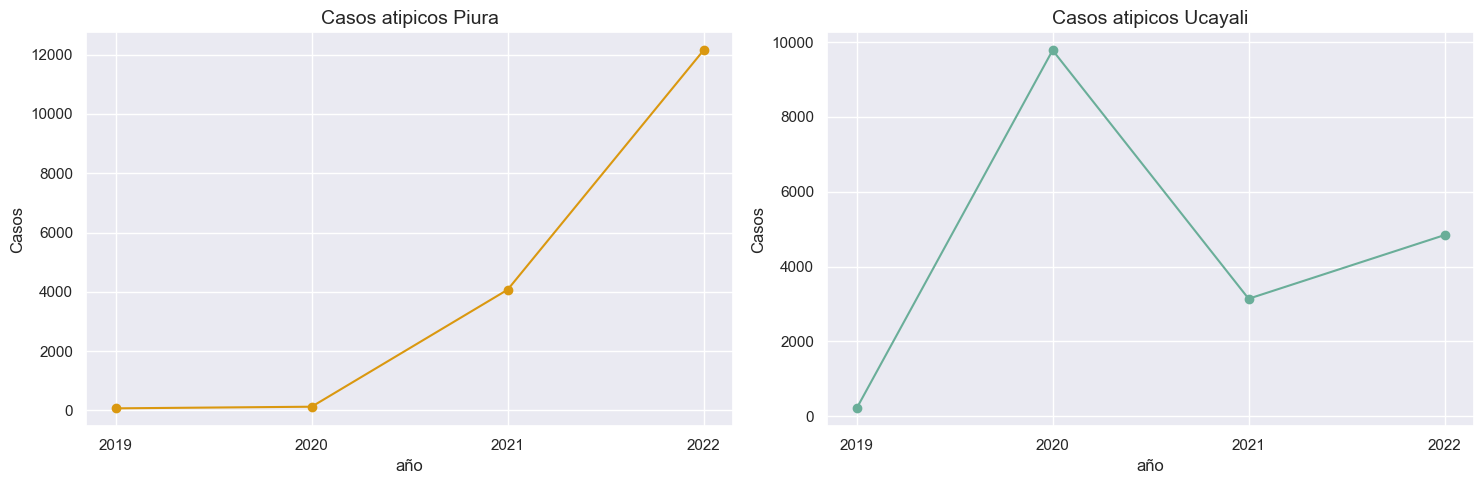

In [15]:
# Agrupamos por departamento y ano
casos_por_departamento_ano = data.groupby(['departamento', 'ano'], observed=False).size().reset_index(name='casos')
casos_por_departamento_ano["ano"] = casos_por_departamento_ano["ano"].astype('str')

# Calculador el z-score
z_score = zscore(casos_por_departamento_ano['casos'])

# Definimos el umbral para considerar un valor como atípico
threshold = 3

# Filtramos los valores atípicos
outliers_por_departamento_ano = casos_por_departamento_ano[z_score > threshold]

print(outliers_por_departamento_ano)

# Gráfico de los departamentos con casos atípicos
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Etiquetas
axs[0].set_title('Casos atipicos Piura', fontsize=14)
axs[0].set_xlabel('año', fontsize=12)
axs[0].set_ylabel('Casos', fontsize=12)
axs[0].plot(casos_por_departamento_ano[casos_por_departamento_ano['departamento'] == "PIURA"]['ano'], casos_por_departamento_ano[casos_por_departamento_ano['departamento'] == "PIURA"]['casos'], marker='o', color='#da9810')

axs[1].set_title('Casos atipicos Ucayali', fontsize=14)
axs[1].set_xlabel('año', fontsize=12)
axs[1].set_ylabel('Casos', fontsize=12)
axs[1].plot(casos_por_departamento_ano[casos_por_departamento_ano['departamento'] == "UCAYALI"]['ano'], casos_por_departamento_ano[casos_por_departamento_ano['departamento'] == "UCAYALI"]['casos'],  marker='o', color="#6aae99")

fig.tight_layout()
plt.show()


### Que genero tiene mas casos a lo largo de los años?

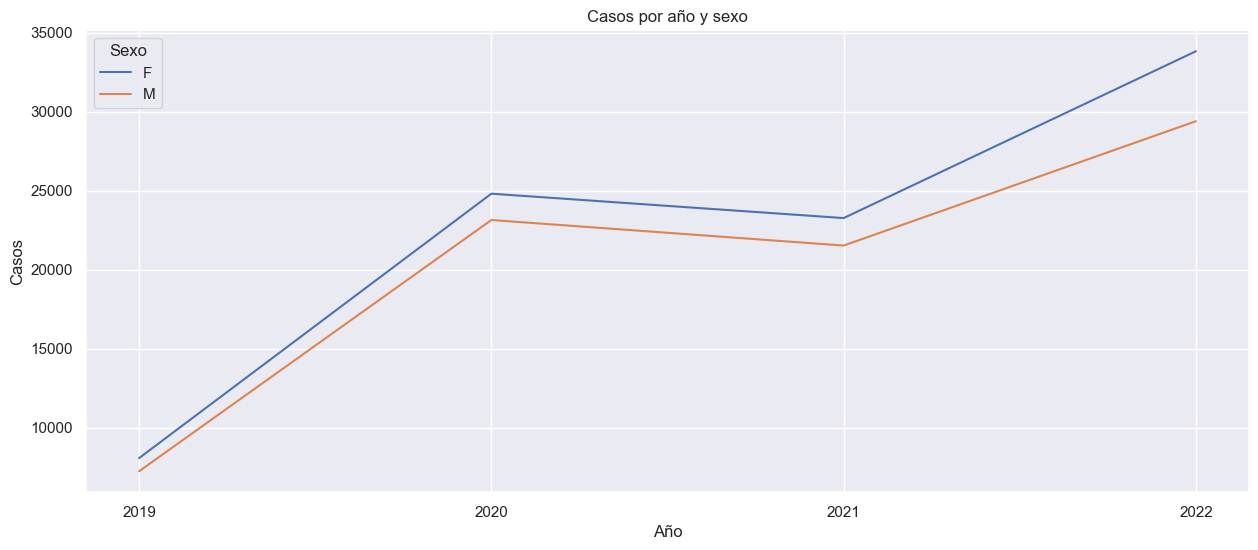

    ano sexo  casos
0  2019    F   8072
1  2019    M   7239
2  2020    F  24810
3  2020    M  23144
4  2021    F  23266
5  2021    M  21526
6  2022    F  33827
7  2022    M  29398


In [16]:
# Agrupamos por sexo y ano

casos_por_ano_sexo = data.groupby(['ano', 'sexo'], observed=False).size().reset_index(name='casos')
casos_por_ano_sexo["ano"] = casos_por_ano_sexo["ano"].astype('str')

# Gráfico de los casos por año y sexo
plt.figure(figsize=(15, 6))
ax = sns.lineplot(data=casos_por_ano_sexo, x='ano', y='casos', hue='sexo')

# Etiquetas
plt.xlabel('Año')
plt.ylabel('Casos')
plt.title('Casos por año y sexo')
plt.legend(title='Sexo', loc='upper left')
plt.show()

print(casos_por_ano_sexo)


### Casos de denge por genero y departamento a lo largo de los años

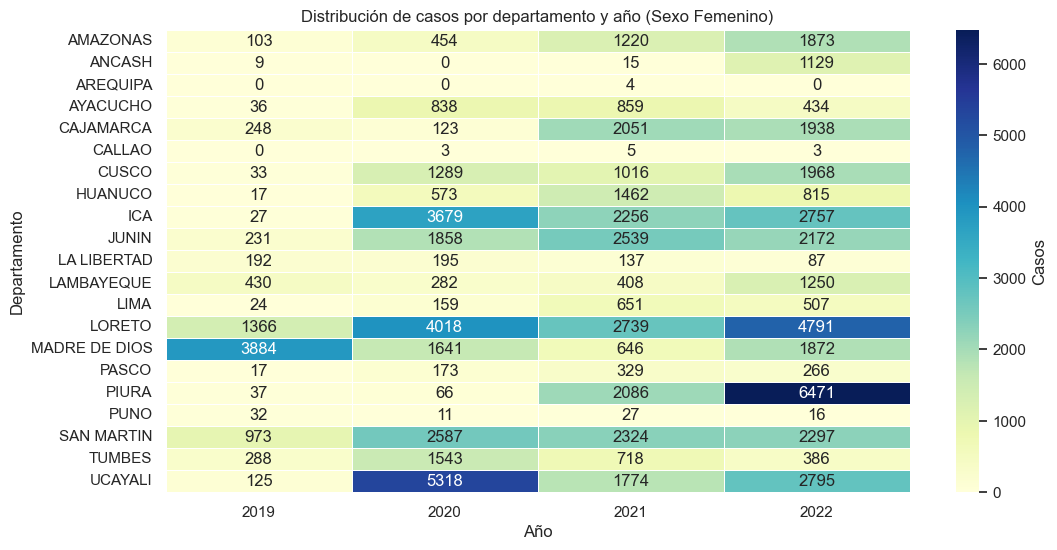

In [17]:
casos_por_sexo_departamento_ano = data.groupby(['departamento', 'ano', 'sexo'], observed=False).size().reset_index(name='casos')
# Teniendo en cuenta que el sexo femenino es el que tiene mayor cantidad de casos, graficamos por medio de un grafico de calor

heatmap_data = casos_por_sexo_departamento_ano[casos_por_sexo_departamento_ano['sexo'] == 'F'].pivot(index='departamento', columns='ano', values='casos')

sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d', cbar_kws={'label': 'Casos'}, linewidths=0.5)

plt.title('Distribución de casos por departamento y año (Sexo Femenino)')
plt.xlabel('Año')
plt.ylabel('Departamento')
plt.show()


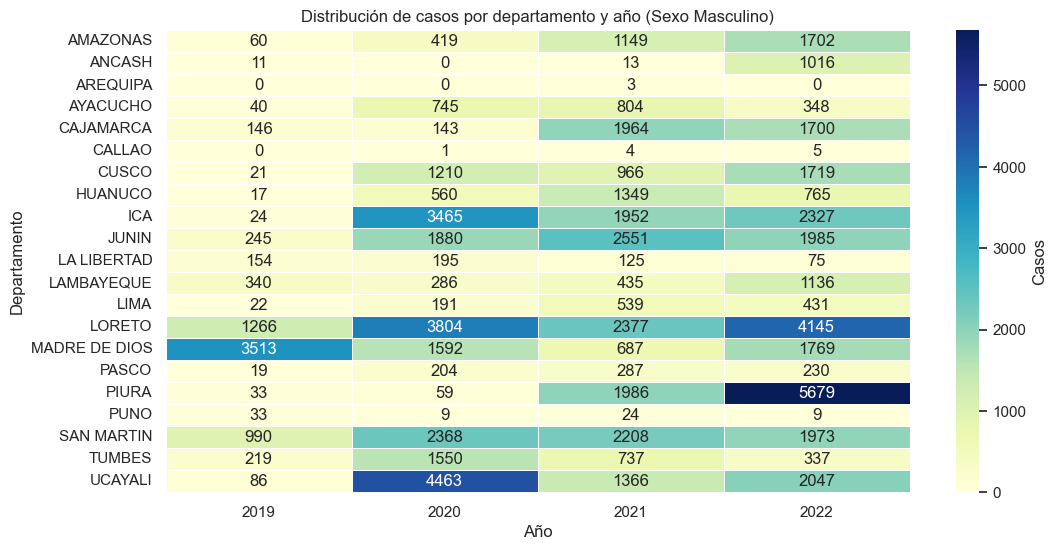

In [18]:
# Mapa de calos de los casos por departamento y año para el sexo masculino
heatmap_data = casos_por_sexo_departamento_ano[casos_por_sexo_departamento_ano['sexo'] == 'M'].pivot(index='departamento', columns='ano', values='casos')

sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d', cbar_kws={'label': 'Casos'}, linewidths=0.5)

plt.title('Distribución de casos por departamento y año (Sexo Masculino)')
plt.xlabel('Año')
plt.ylabel('Departamento')
plt.show()


### Casos de denge por enfermedad y sexo

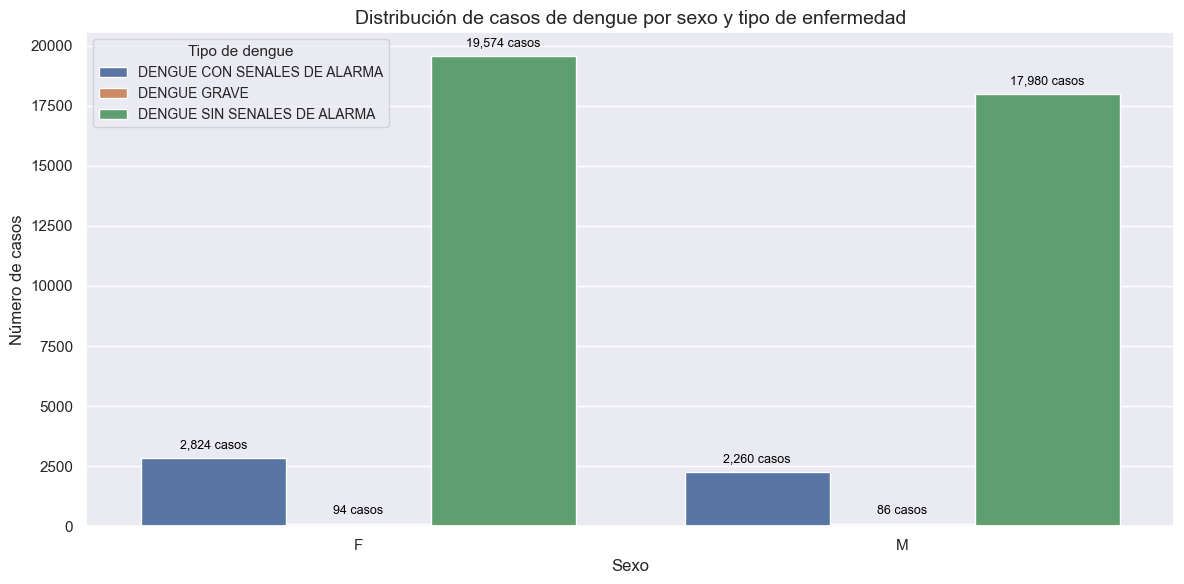

In [19]:
# Agrupar y contar
# conteo = data.groupby('sexo', observed=False)['enfermedad'].value_counts().rename("cantidad").reset_index()
enfermedad_por_sexo = data.groupby(['sexo', 'ano'], observed=False)['enfermedad'].value_counts().reset_index(name='cantidad').sort_values(by="cantidad", ascending=False)

grafico = sns.barplot(data=enfermedad_por_sexo, x='sexo', y='cantidad', hue='enfermedad', errorbar=None)

for p in grafico.patches:
    altura = p.get_height()
    if altura > 0:
        grafico.annotate(f'{int(altura):,} casos',  # separador de miles
                         (p.get_x() + p.get_width() / 2., altura),
                         ha='center', va='bottom',
                         fontsize=9, color='black', xytext=(0, 5),
                         textcoords='offset points')

# Títulos y etiquetas
plt.title("Distribución de casos de dengue por sexo y tipo de enfermedad", fontsize=14)
plt.ylabel("Número de casos", fontsize=12)
plt.xlabel("Sexo", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title="Tipo de dengue", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.savefig('capturas/grafico_sexo_enfermedad.png', dpi=300)
plt.show()


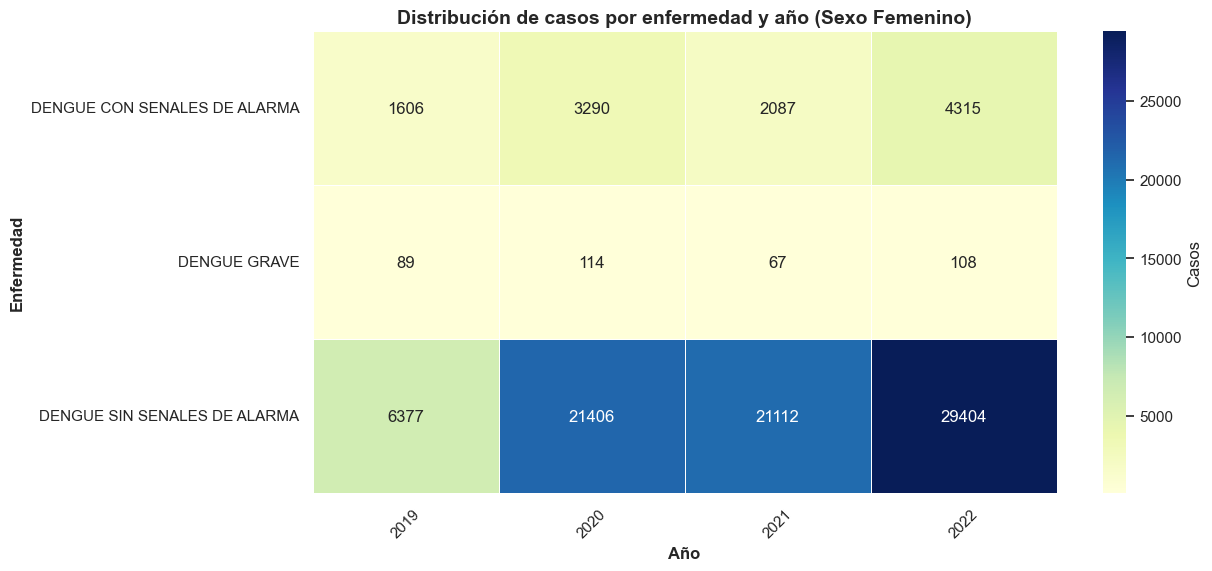

In [20]:
# Mapa de calor de los casos por enfermedad y sexp
mapa_mujer = enfermedad_por_sexo[enfermedad_por_sexo['sexo'] == 'F'].pivot(index='enfermedad', columns='ano', values='cantidad') 

sns.heatmap(mapa_mujer, cmap='YlGnBu', annot=True, fmt='d', cbar_kws={'label': 'Casos'}, linewidths=0.5)

# Etiquetas
plt.title('Distribución de casos por enfermedad y año (Sexo Femenino)', fontsize=14, fontweight='bold')
plt.xlabel('Año', fontsize=12, fontweight='bold')
plt.ylabel('Enfermedad', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.savefig('capturas/mapa_calor_sexo_femenino.png', dpi=300)
plt.show()


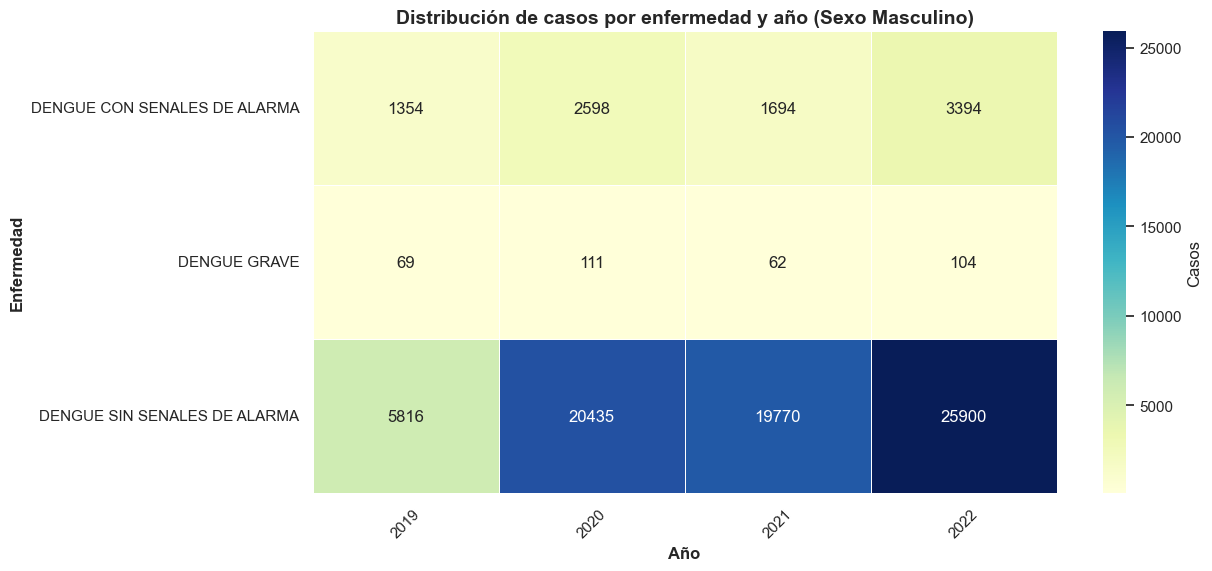

In [21]:
# Mapa de calor de los casos por enfermedad y sexp
mapa_mujer = enfermedad_por_sexo[enfermedad_por_sexo['sexo'] == 'M'].pivot(index='enfermedad', columns='ano', values='cantidad') 

sns.heatmap(mapa_mujer, cmap='YlGnBu', annot=True, fmt='d', cbar_kws={'label': 'Casos'}, linewidths=0.5)

# Etiquetas
plt.title('Distribución de casos por enfermedad y año (Sexo Masculino)', fontsize=14, fontweight='bold')
plt.xlabel('Año', fontsize=12, fontweight='bold')
plt.ylabel('Enfermedad', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.savefig('capturas/mapa_calor_sexo_masculino.png', dpi=300)

plt.show()

### Casos de denge por edad en el peru

In [43]:
# Cual es la edad promedio de los casos reportados?
print(f"Edad promedio de los casos reportados: {data['edad'].mean():.0f}") # promedio de los casos reportados es de 28 años
print("El grupo de edad con mayor casos reportados es de: ", data['grupo_edad'].mode()[0]) # el grupo de edad mas frecuente es "joven"

Edad promedio de los casos reportados: 29
El grupo de edad con mayor casos reportados es de:  adulto mayor


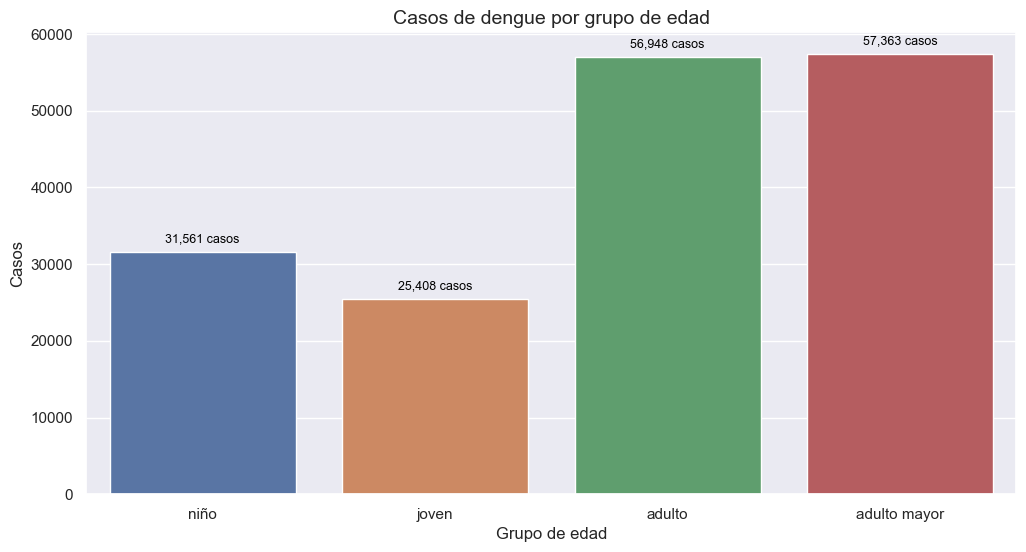

In [ ]:
# Casos de dengue por grupo de edad

casos_por_edad = data.groupby("grupo_edad", observed=False).size().reset_index(name='casos')

px = sns.barplot(data=casos_por_edad, x='grupo_edad', y='casos', hue='grupo_edad')

# Etiquetas
plt.title('Casos de dengue por grupo de edad', fontsize=14)
plt.xlabel('Grupo de edad', fontsize=12)
plt.ylabel('Casos', fontsize=12)

for p in px.patches:
    altura = p.get_height()
    if altura > 0:
        px.annotate(f'{int(altura):,} casos',  # separador de miles
                     (p.get_x() + p.get_width() / 2., altura),
                     ha='center', va='bottom',
                     fontsize=9, color='black', xytext=(0, 5),
                     textcoords='offset points')

plt.savefig('capturas/casos_por_grupo_edad.png', dpi=300)
plt.show()


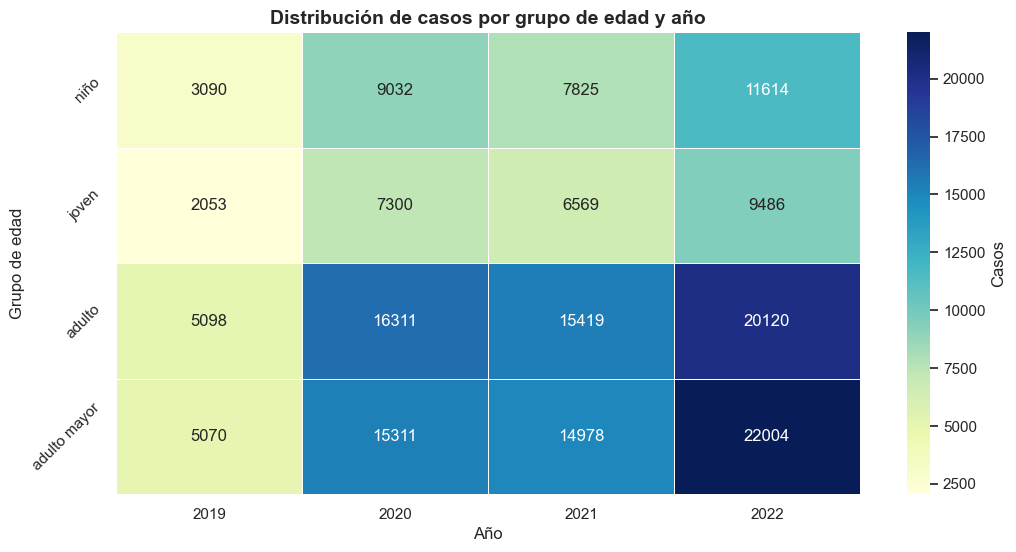

In [54]:
# Mapa de calor de los casos por grupo de edad y año
edad_ano = data.groupby(['grupo_edad', 'ano'], observed=False).size().reset_index(name='casos')
mapa_edad_ano = edad_ano.pivot(index='grupo_edad', columns='ano', values='casos')

sns.heatmap(mapa_edad_ano, cmap='YlGnBu', annot=True, fmt='d', cbar_kws={'label': 'Casos'}, linewidths=0.5)

# Etiquetas
plt.title('Distribución de casos por grupo de edad y año', fontsize=14, fontweight='bold')
plt.ylabel('Grupo de edad', fontsize=12)
plt.xlabel('Año', fontsize=12)
plt.yticks(rotation=45)

plt.savefig('capturas/mapa_calor_grupo_edad.png', dpi=300)
plt.show()




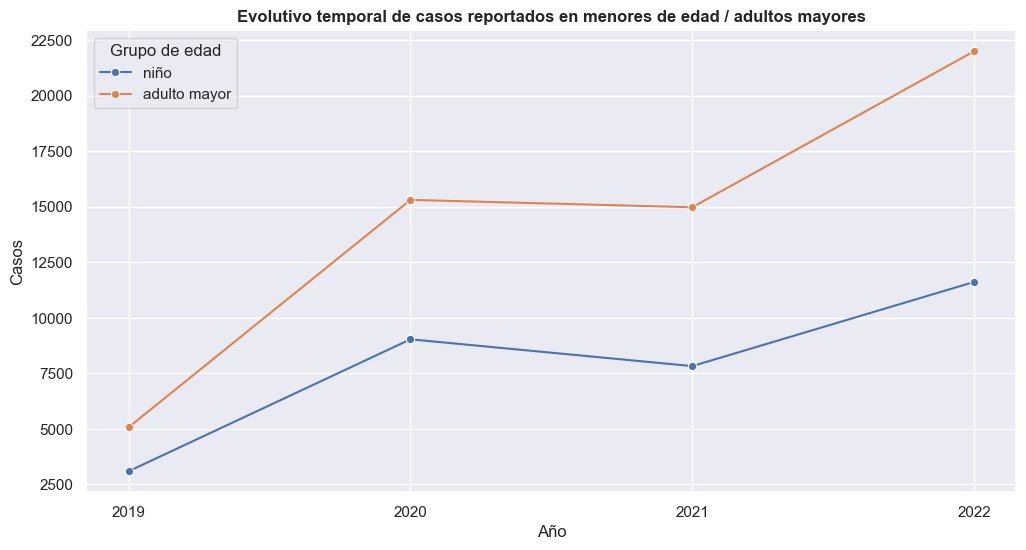

In [23]:
# ¿En qué año se reportaron más casos en menores de edad / adultos mayores?
caso_mayores_menores = data[data['grupo_edad'].isin(['adulto mayor', 'niño'])].groupby(['ano', 'grupo_edad'], observed=True).size().reset_index(name= 'casos')
caso_mayores_menores['grupo_edad'] = caso_mayores_menores['grupo_edad'].astype(str)
caso_mayores_menores['ano'] = caso_mayores_menores['ano'].astype(str)
sns.lineplot(data=caso_mayores_menores, x='ano', y='casos', hue='grupo_edad', marker='o')

plt.title('Evolutivo temporal de casos reportados en menores de edad / adultos mayores', fontweight='bold')
plt.ylabel('Casos')
plt.xlabel('Año')
plt.legend(title='Grupo de edad')
plt.show()